# Reparametrization notebook
Getting some insight on how reparametrization affects the data

In [1]:
import numpy as np
import pandas as pd
# import google.datalab.bigquery as bq
from google.cloud import storage
from io import StringIO
import sys
sys.path.append("../model")
#import utils.hough as hg
import matplotlib.pyplot as plt
from scipy.stats.mstats import normaltest
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn import metrics

First, import all hits from one specific event. Here, this is done from the BigQuery:

In [2]:
eventId = 1000
# event_query = bq.Query('SELECT * FROM train.events WHERE event_id = {};'.format(eventId)) # Write SQL query to be executed
# event = event_query.execute().result()#output_options=bq.QueryOutput.dataframe()).result() # Execute SQL query to get Table
# event_df = event_res.to_dataframe() # Convert output Table to Pandas DataFrame, but it does not work.

And here, from the bucket:

In [3]:
client = storage.Client()
bucket = client.get_bucket('trackrecon-204713')

In [4]:
hit_blob = bucket.get_blob('vanilla/event00000%s-hits.csv'%eventId)
hit_str = hit_blob.download_as_string().decode("utf8")
hit_df = pd.read_csv(StringIO(hit_str))

In [5]:
particle_blob = bucket.get_blob('vanilla/event00000%s-particles.csv'%eventId)
particle_str = particle_blob.download_as_string().decode("utf8")
particle_df = pd.read_csv(StringIO(particle_str))

In [6]:
truth_blob = bucket.get_blob('vanilla/event00000%s-truth.csv'%eventId)
truth_str = truth_blob.download_as_string().decode("utf8")
truth_df = pd.read_csv(StringIO(truth_str))

In [7]:
truth_n0 = truth_df.drop(truth_df[truth_df.particle_id == 0].index, inplace=False) # getting rid of noise (particle_id = 0)

In [8]:
truth_s = truth_n0.iloc[np.lexsort((truth_n0.tz.values, truth_n0.particle_id.values))] # sorting particles by partice_id then z for plotting

hit_id       particle_id          tx        ty        tz       tpx  \
113564  113565  4503668346847232 -1010.74000  125.9050 -862.7860 -0.120391   
87264    87265  4503668346847232  -303.83400  396.1700 -325.0320 -0.288603   
80880    80881  4503668346847232  -177.02000  315.5940 -231.3750 -0.246460   
73762    73763  4503668346847232  -105.02200  240.3690 -166.4490 -0.200451   
42237    42238  4503668346847232   -54.55930  162.8260 -108.4750 -0.151918   
35620    35621  4503668346847232   -31.18840  112.0460  -73.2019 -0.118230   
29322    29323  4503668346847232   -16.96210   71.0005  -45.6381 -0.096428   
20879    20880  4503668346847232    -6.37305   31.6019  -20.0800 -0.074873   
23345    23346  4503737066323968   -28.03780   14.2389   59.5942 -0.939812   
31386    31387  4503737066323968   -63.94690   33.4354  136.8850 -0.927717   

             tpy       tpz    weight  
113564 -0.286054 -0.203332  0.000011  
87264   0.130892 -0.198512  0.000009  
80880   0.210003 -0.201005  0.000005  
73762   0.254855 -0.201860  0.000005  
42237   0.287370 -0.204184  0.000008  
35620   0.302181 -0.206065  0.000010  
29322   0.311619 -0.204427  0.000014  
20879   0.319162 -0.203232  0.000018  
23345   0.487721  2.009650  0.000026  
31386   0.509620  2.009250  0.000022

In [12]:
ID = 22525763437723648
one_track = truth_s[truth_s.particle_id == ID]

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


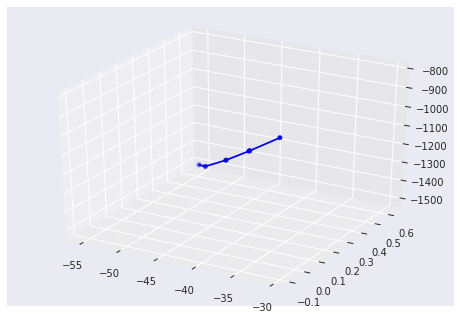

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(one_track['tx'], one_track['ty'], one_track['tz'], c="blue")
ax.plot(one_track['tx'], one_track['ty'], one_track['tz'], c="blue")
plt.show()

Plotting several tracks

In [9]:
n_track = 200
start = 1000
IDs = list(set(truth_s['particle_id'].tolist()))
IDs_short = IDs[start:start + n_track]

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


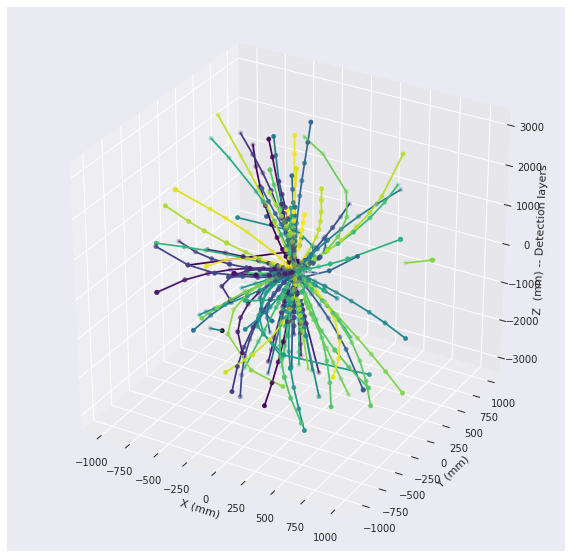

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z  (mm) -- Detection layers')
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(IDs_short))]
for idx, ID in enumerate(IDs_short):
    temp_track = truth_s[truth_s.particle_id == ID]
    ax.scatter(temp_track['tx'], temp_track['ty'], temp_track['tz'], c = colors[idx])
    ax.plot(temp_track['tx'], temp_track['ty'], temp_track['tz'], c = colors[idx])
plt.show()

Attempt at straightening out these lines...

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


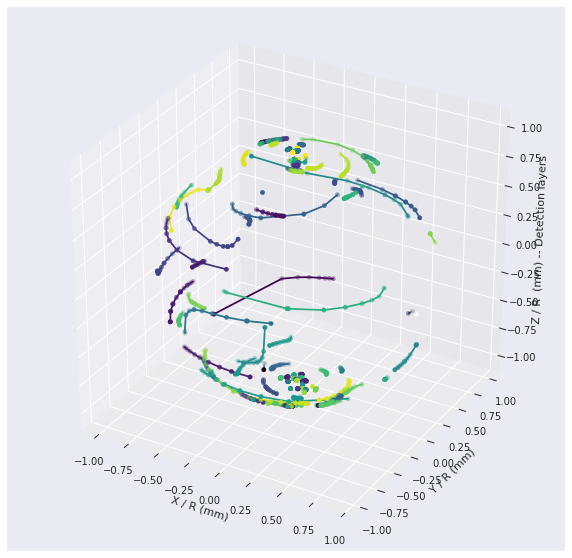

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X / R (mm)')
ax.set_ylabel('Y / R (mm)')
ax.set_zlabel('Z / R  (mm) -- Detection layers')
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(IDs_short))]
for idx, ID in enumerate(IDs_short):
    temp_track = truth_s[truth_s.particle_id == ID]
    radius = np.sqrt(np.power(temp_track['tx'], 2) + np.power(temp_track['ty'], 2) + np.power(temp_track['tz'], 2))
    ax.scatter(temp_track['tx'] / radius, temp_track['ty'] / radius, temp_track['tz'] / radius, c = colors[idx])
    ax.plot(temp_track['tx'] / radius, temp_track['ty'] / radius, temp_track['tz'] / radius, c = colors[idx])
plt.show()

Yeah... No.

Projected down along the z axis...

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


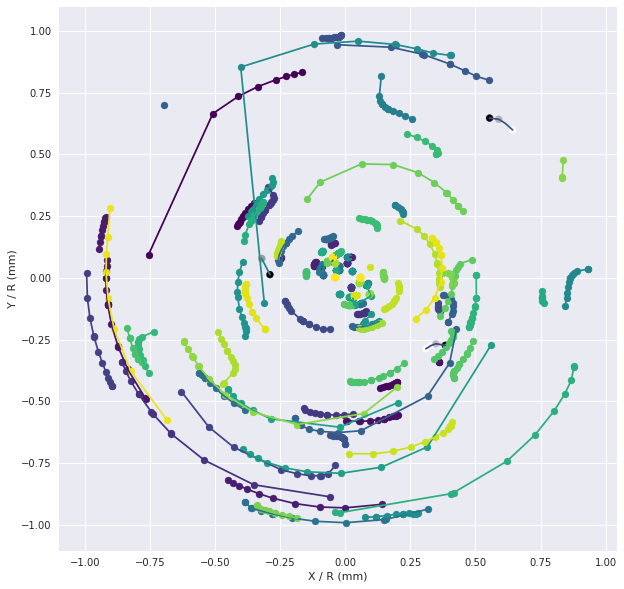

In [27]:
fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
plt.xlabel('X / R (mm)')
plt.ylabel('Y / R (mm)')
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(IDs_short))]
for idx, ID in enumerate(IDs_short):
    temp_track = truth_s[truth_s.particle_id == ID]
    radius = np.sqrt(np.power(temp_track['tx'], 2) + np.power(temp_track['ty'], 2) + np.power(temp_track['tz'], 2))
    plt.scatter(temp_track['tx'] / radius, temp_track['ty'] / radius, c = colors[idx])
    plt.plot(temp_track['tx'] / radius, temp_track['ty'] / radius, c = colors[idx])
plt.show()

And now along x axis

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


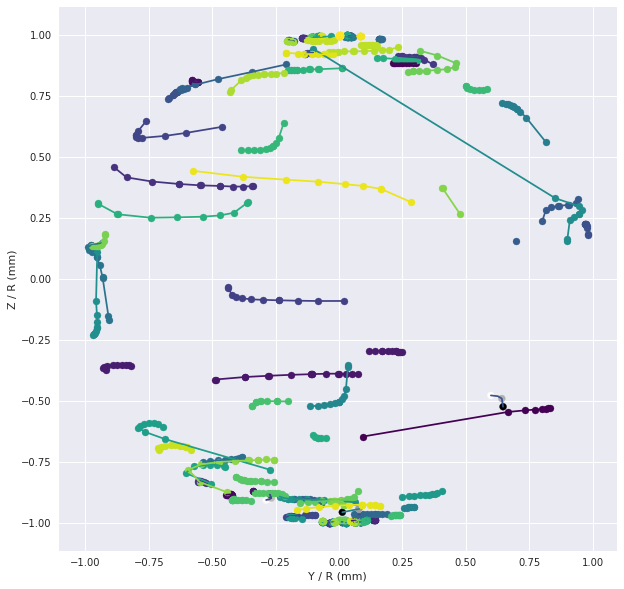

In [30]:
fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
plt.xlabel('Y / R (mm)')
plt.ylabel('Z / R (mm)')
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(IDs_short))]
for idx, ID in enumerate(IDs_short):
    temp_track = truth_s[truth_s.particle_id == ID]
    radius = np.sqrt(np.power(temp_track['tx'], 2) + np.power(temp_track['ty'], 2) + np.power(temp_track['tz'], 2))
    plt.scatter(temp_track['ty'] / radius, temp_track['tz'] / radius, c = colors[idx])
    plt.plot(temp_track['ty'] / radius, temp_track['tz'] / radius, c = colors[idx])
plt.show()

How about r/R?

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


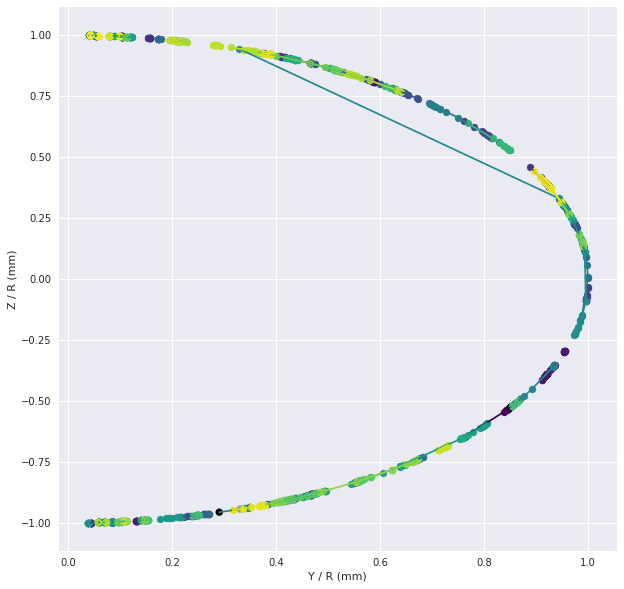

In [31]:
fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
plt.xlabel('Y / R (mm)')
plt.ylabel('Z / R (mm)')
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(IDs_short))]
for idx, ID in enumerate(IDs_short):
    temp_track = truth_s[truth_s.particle_id == ID]
    radius = np.sqrt(np.power(temp_track['tx'], 2) + np.power(temp_track['ty'], 2))
    Radius = np.sqrt(np.power(temp_track['tx'], 2) + np.power(temp_track['ty'], 2) + np.power(temp_track['tz'], 2))
    plt.scatter(radius / Radius, temp_track['tz'] / Radius, c = colors[idx])
    plt.plot(radius / Radius, temp_track['tz'] / Radius, c = colors[idx])
plt.show()

Other attempt at straightening...

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


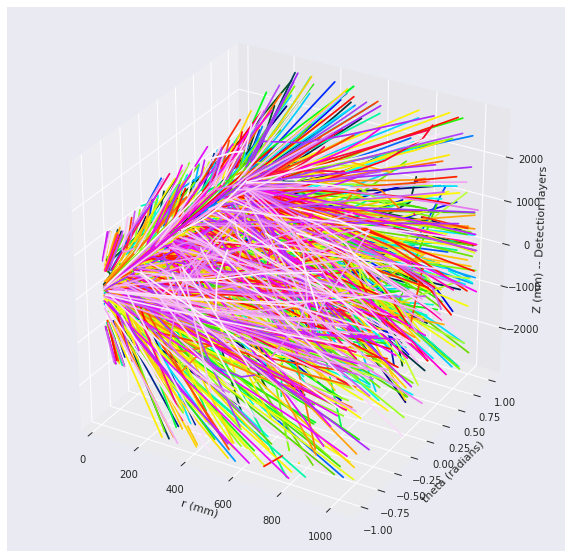

In [82]:
n_track = 1000
start = 1000
IDs = list(set(truth_s['particle_id'].tolist()))
IDs_short = IDs[start:start + n_track]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('r (mm)')
ax.set_ylabel('theta (radians)')
ax.set_zlabel('Z (mm) -- Detection layers')
colormap = plt.cm.gist_ncar
colors = [colormap(i) for i in np.linspace(0, 1,len(IDs_short))]
for idx, ID in enumerate(IDs_short):
    temp_track = truth_s[truth_s.particle_id == ID]
    radius = np.sqrt(np.power(temp_track['tx'], 2) + np.power(temp_track['ty'], 2))
    theta = np.arctan2(temp_track['ty'], temp_track['tx'])
    r = np.sqrt(np.power(radius, 2) + np.power(temp_track['tz'], 2))
    #ax.scatter(radius,theta, temp_track['tz'], c = colors[idx])
    ax.plot(radius, np.cos(theta), temp_track['tz'], c = colors[idx])
#ax.set_xlim(-100,100)
#ax.set_ylim(-1,1)
#ax.set_zlim(-100,100)
plt.show()

Projecting onto a cylinder

In [11]:
n_track = 250
start = 80
IDs = list(set(truth_s['particle_id'].tolist()))
IDs_short = IDs[start:start + n_track]

X = np.empty([1,3])

for idx, ID in enumerate(IDs_short):
    temp_track = truth_s[truth_s.particle_id == ID]
    radius = np.sqrt(np.power(temp_track['tx'], 2) + np.power(temp_track['ty'], 2))
    theta = np.arctan2(temp_track['ty'], temp_track['tx'])
    r = np.sqrt(np.power(radius, 2) + np.power(temp_track['tz'], 2))
    #print('r: ', r, 'ID: ', ID)
    X = np.append(X, np.array((list(radius / r), list(theta), list(temp_track['tz'] / r))).transpose(), axis = 0)

Trying DBSCAN on the result

In [40]:
db = DBSCAN(eps=.07, min_samples = 2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


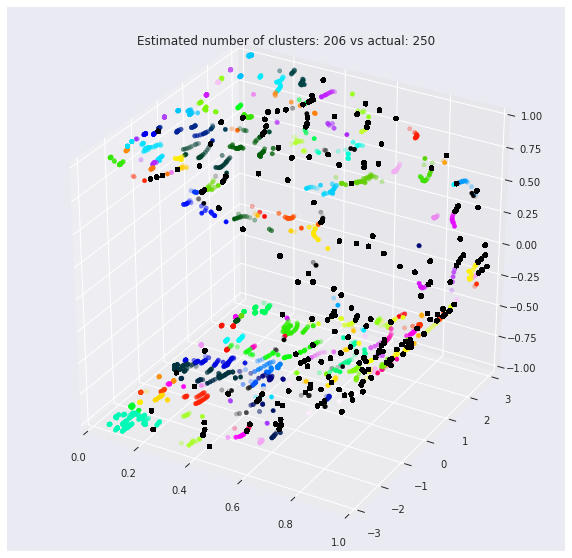

In [47]:
unique_labels = set(labels)
colormap = plt.cm.gist_ncar
colors = [colormap(i) for i in np.linspace(0, 1,n_clusters_)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=col)#, markerfacecolor=tuple(col),
             # markeredgecolor='k', markersize=14)

    xy = X[~class_member_mask & ~core_samples_mask]
    ax.scatter(xy[:,0], xy[:,1], xy[:,2], 'o', c='k')#, markerfacecolor=tuple(col),
             # markeredgecolor='k', markersize=6)
ax.set_xlim((0, 1))
ax.set_ylim((-np.pi, np.pi))
ax.set_zlim((-1, 1))
plt.title("Estimated number of clusters: %d vs actual: %d"%(n_clusters_,n_track))
plt.show()

In [251]:
from collections import Counter
Counter(labels)

Counter({-1: 84,
         0: 414,
         1: 2,
         2: 14,
         3: 7,
         4: 5,
         5: 19,
         6: 248,
         7: 49,
         8: 40,
         9: 3,
         10: 28,
         11: 103,
         12: 4,
         13: 10,
         14: 27,
         15: 24,
         16: 19,
         17: 2,
         18: 3,
         19: 12,
         20: 37,
         21: 26,
         22: 26,
         23: 2,
         24: 4,
         25: 29,
         26: 5,
         27: 10,
         28: 252,
         29: 2,
         30: 6,
         31: 4,
         32: 38,
         33: 6,
         34: 124,
         35: 7,
         36: 12,
         37: 9,
         38: 26,
         39: 12,
         40: 3,
         41: 2,
         42: 5,
         43: 12,
         44: 4,
         45: 8,
         46: 25,
         47: 2,
         48: 7,
         49: 6,
         50: 12,
         51: 2,
         52: 9,
         53: 12,
         54: 4,
         55: 24,
         56: 7,
         57: 2,
         58: 14,
         59: 1

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


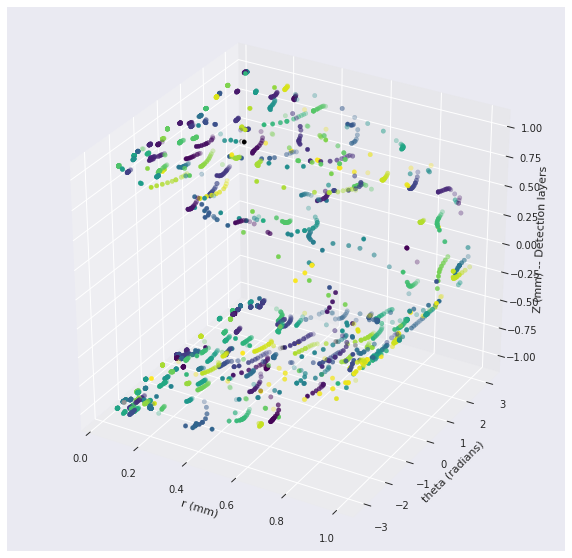

In [18]:
n_track = 250
start = 80
IDs = list(set(truth_s['particle_id'].tolist()))
IDs_short = IDs[start:start + n_track]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('r (mm)')
ax.set_ylabel('theta (radians)')
ax.set_zlabel('Z (mm) -- Detection layers')
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(IDs_short))]
for idx, ID in enumerate(IDs_short):
    temp_track = truth_s[truth_s.particle_id == ID]
    radius = np.sqrt(np.power(temp_track['tx'], 2) + np.power(temp_track['ty'], 2))
    theta = np.arctan2(temp_track['ty'], temp_track['tx'])
    r = np.sqrt(np.power(radius, 2) + np.power(temp_track['tz'], 2))
    ax.scatter(radius / r, theta, temp_track['tz'] / r, c = colors[idx])
    #ax.plot(radius / r, theta, temp_track['tz'] / r, c = colors[idx])
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


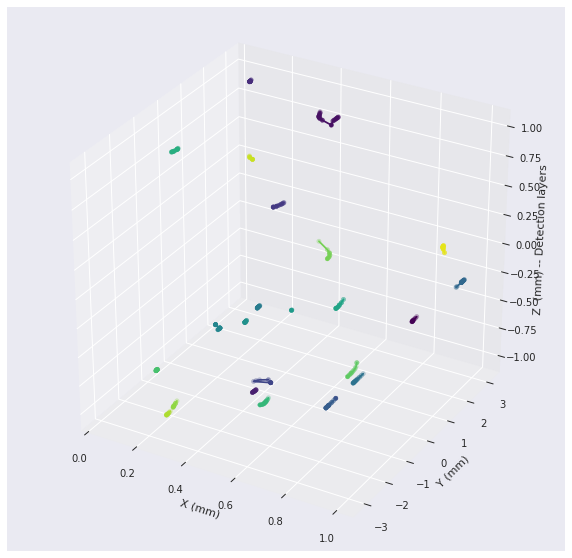

In [194]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z  (mm) -- Detection layers')
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(IDs_short))]
for idx in range(n_clusters_):
    x =X[db.labels_== idx]
    ax.scatter(x[:,0], x[:,1], x[:,2], c = colors[idx])
    ax.plot(x[:,0], x[:,1], x[:,2], c = colors[idx])
plt.show()